In [1]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b1c25eac09cf08f50b887e65116e2b1b0e412ceee31f0365262de98388d278fa
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime

import numpy as np
import pandas as pd
import seaborn as sb
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Set color palette for graphs
sns.set_palette('pastel')

In [4]:
pip install seaborn

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [7]:
# check that our Spark session has been created
spark.sparkContext.getConf().getAll()
spark

In [8]:
# Download the JSON file locally
import requests

url = "https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json"
response = requests.get(url)

# Save the content to a local file
with open("mini_sparkify_event_data.json", "wb") as file:
    file.write(response.content)

# Read the local JSON file into a PySpark DataFrame
df = spark.read.json("mini_sparkify_event_data.json")

In [9]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Describe the DataFrame to understand its structure and summary statistics
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [11]:
# number of columns in dataframe
len(df.columns)

18

In [12]:
# number of samples in dataframe
df.count()

286500

In [13]:
# print first 5 rows as pandas dataframe
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [14]:
df.describe(['artist']).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [15]:
df.describe(['auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location']).show()

+-------+----------+---------+------+------------------+--------+------------------+------+-----------------+
|summary|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|
+-------+----------+---------+------+------------------+--------+------------------+------+-----------------+
|  count|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|
|   mean|      NULL|     NULL|  NULL|114.41421291448516|    NULL|249.11718197783662|  NULL|             NULL|
| stddev|      NULL|     NULL|  NULL|129.76726201141042|    NULL| 99.23517921058307|  NULL|             NULL|
|    min| Cancelled| Adelaida|     F|                 0|   Adams|           0.78322|  free|       Albany, OR|
|    max|Logged Out|   Zyonna|     M|              1321|  Wright|        3024.66567|  paid|Winston-Salem, NC|
+-------+----------+---------+------+------------------+--------+------------------+------+-----------------+



In [16]:
df.groupBy('auth').count().sort(desc('count')).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [17]:
df.groupBy('gender').count().sort(desc('count')).show()


+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  NULL|  8346|
+------+------+



In [18]:
df.groupBy('level').count().sort(desc('count')).show()


+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



In [19]:
df.describe(['method', 'page', 'registration', 'sessionId']).show()

+-------+------+-------+--------------------+-----------------+
|summary|method|   page|        registration|        sessionId|
+-------+------+-------+--------------------+-----------------+
|  count|286500| 286500|              278154|           286500|
|   mean|  NULL|   NULL|1.535358834085650...|1041.526554973822|
| stddev|  NULL|   NULL|  3.29132161632862E9|726.7762634630783|
|    min|   GET|  About|       1521380675000|                1|
|    max|   PUT|Upgrade|       1543247354000|             2474|
+-------+------+-------+--------------------+-----------------+



In [20]:
df.groupBy('method').count().sort(desc('count')).show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



In [21]:
df.groupBy('page').count().sort(desc('count')).show(30, truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



In [22]:
df.describe(['song']).show()

+-------+--------------------+
|summary|                song|
+-------+--------------------+
|  count|              228108|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|ÃÂg ÃÂtti Gr...|
|    max|ÃÂau hafa slopp...|
+-------+--------------------+



In [23]:
df.describe(['status', 'ts', 'userAgent', 'userId']).show()

+-------+------------------+--------------------+--------------------+------------------+
|summary|            status|                  ts|           userAgent|            userId|
+-------+------------------+--------------------+--------------------+------------------+
|  count|            286500|              286500|              278154|            286500|
|   mean|210.05459685863875|1.540956889810432E12|                NULL| 59682.02278593872|
| stddev|31.505078488422217| 1.507543960818767E9|                NULL|109091.94999910527|
|    min|               200|       1538352117000|"Mozilla/5.0 (Mac...|                  |
|    max|               404|       1543799476000|Mozilla/5.0 (comp...|                99|
+-------+------------------+--------------------+--------------------+------------------+



In [24]:
df.groupBy('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259812|
+------+------+



In [25]:
# find NaNs and Nulls in dataframe
# source: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [26]:
# find empty strings in dataframe
df.select([count(when(col(c) == '', c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [27]:
# show first 20 rows with empty 'userId' as pandas dataframe
df.where(col('userId') == '').toPandas().head(20)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,NaN,free,None,PUT,Login,NaN,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,NaN,free,None,GET,Home,NaN,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,NaN,free,None,PUT,Login,NaN,187,None,307,1538361528000,None,


In [28]:
# print distinct values for column 'auth' where 'userId' is empty
df.select('auth').where(col('userId') == '').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [29]:
# show first 20 rows with missing values in 'artist' as pandas dataframe
df.where(isnan(df['artist']) | df['artist'].isNull()).toPandas().head(20)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0,54
5,None,Logged In,Micah,M,95,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1.538332e+12,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
6,None,Logged In,Micah,M,97,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1.538332e+12,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
7,None,Logged In,Micah,M,99,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1.538332e+12,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
8,None,Logged In,Ashlynn,F,9,Williams,NaN,free,"Tallahassee, FL",PUT,Thumbs Up,1.537365e+12,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36""",74
9,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,


In [30]:
# print distinct values for column 'page' where 'artist' has missing value
df.select('page').where(isnan(df['artist']) | df['artist'].isNull()).distinct().show(50, truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [31]:
# compare distinct values for column 'page' for entire dataset and subset only including rows where 'artist' has missing value
set(df.select('page').distinct().collect()) - set(
    df.select('page').where(isnan(df['artist']) | df['artist'].isNull()).distinct().collect())

{Row(page='NextSong')}

In [32]:
# drop rows with no user data (Logged Out or Guest)
df_clean = df.where(col('userId') != '')

In [33]:
# number of rows after removal
print(df_clean.count())

278154


In [34]:
# check NaNs and Nulls in new dataframe
df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [35]:
import datetime
from pyspark.sql.functions import udf

In [36]:
# udf to convert timestamp to correct format
# source: https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe
get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

# apply udf to registration timestamp
df_clean = df_clean.withColumn('registration', get_timestamp(df_clean['registration']))

# apply udf to ts timestamp
df_clean = df_clean.withColumn('ts', get_timestamp(df_clean['ts']))

In [37]:
import os

os.environ["PYSPARK_PYTHON"] = "python3.10"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3.10"

In [38]:
df_clean.select('registration').show()

+-------------------+
|       registration|
+-------------------+
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-28 22:22:42|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-19 13:53:39|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
+-------------------+
only showing top 20 rows



In [39]:
df_clean.select('ts').show()

+-------------------+
|                 ts|
+-------------------+
|2018-10-01 00:01:57|
|2018-10-01 00:03:00|
|2018-10-01 00:06:34|
|2018-10-01 00:06:56|
|2018-10-01 00:11:16|
|2018-10-01 00:11:18|
|2018-10-01 00:14:46|
|2018-10-01 00:14:59|
|2018-10-01 00:15:05|
|2018-10-01 00:18:04|
|2018-10-01 00:19:06|
|2018-10-01 00:19:10|
|2018-10-01 00:20:18|
|2018-10-01 00:22:55|
|2018-10-01 00:22:56|
|2018-10-01 00:24:01|
|2018-10-01 00:26:16|
|2018-10-01 00:27:48|
|2018-10-01 00:28:07|
|2018-10-01 00:29:04|
+-------------------+
only showing top 20 rows



In [40]:
df_clean.groupBy(year('ts'), month('ts')).count().sort(month('ts')).show()

+--------+---------+------+
|year(ts)|month(ts)| count|
+--------+---------+------+
|    2018|       10|144916|
|    2018|       11|133234|
|    2018|       12|     4|
+--------+---------+------+



In [41]:
# split location column into two, one column with location name and one column with the state
df_clean = df_clean.withColumn('location_name', split(col('location'), ',').getItem(0))
df_clean = df_clean.withColumn('state', split(col('location'), ',').getItem(1))
# keep only the first state
df_clean = df_clean.withColumn('state', split(col('state'), '-').getItem(0))

In [42]:
df_clean.select('location_name').show(truncate=False)

+-----------------------+
|location_name          |
+-----------------------+
|Bakersfield            |
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Bakersfield            |
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Tallahassee            |
|Bakersfield            |
|Boston-Cambridge-Newton|
+-----------------------+
only showing top 20 rows



In [43]:
df_clean.select('state').show()

+-----+
|state|
+-----+
|   CA|
|   MA|
|   CA|
|   MA|
|   CA|
|   MA|
|   MA|
|   CA|
|   CA|
|   CA|
|   MA|
|   MA|
|   CA|
|   MA|
|   MA|
|   CA|
|   MA|
|   FL|
|   CA|
|   MA|
+-----+
only showing top 20 rows



**EDA**

In [44]:
# create new column 'churn'
# churn = 1 (yes) if column page = 'Cancellation Confirmation', else 0 (No)
df_clean = df_clean.withColumn('churn', when(col('page') == 'Cancellation Confirmation', 1).otherwise(0))

# Show counts per value for 'churn'
df_clean.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [45]:
# get userId's where churn = 1
churned_users = df_clean.select('userId').where(col('churn') == 1).groupby('userId').count()

# only keep values from 'userId' column and store as list
# source: https://stackoverflow.com/questions/38610559/convert-spark-dataframe-column-to-python-list
churned_users = [row['userId'] for row in churned_users.collect()]

# print userId's for churned users
churned_users

['125',
 '51',
 '101',
 '87',
 '73',
 '3',
 '28',
 '18',
 '17',
 '103',
 '122',
 '58',
 '106',
 '143',
 '32',
 '105',
 '121',
 '12',
 '129',
 '54',
 '100014',
 '29',
 '100021',
 '100022',
 '100025',
 '300007',
 '100006',
 '70',
 '100005',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '100024',
 '53',
 '200017',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '200001',
 '200011',
 '100023',
 '100013',
 '100017',
 '200015',
 '200021',
 '100001']

In [46]:
# set column 'churn' as 1 for all rows for a churned user
df_clean = df_clean.withColumn('churn', when((df_clean.userId).isin(churned_users), 1).otherwise(0))

# Show counts per value for 'churn'
df_clean.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [47]:
# show all events related to a churned user
df_clean.select(['itemInSession', 'level', 'method', 'page', 'sessionId', 'ts', 'userId', 'churn']).where(col('userId') == 100014).toPandas()

,itemInSession,level,method,page,sessionId,ts,userId,churn
0,0,paid,PUT,NextSong,37,2018-10-10 13:12:16,100014,1
1,1,paid,PUT,NextSong,37,2018-10-10 13:15:51,100014,1
2,2,paid,PUT,NextSong,37,2018-10-10 13:17:56,100014,1
3,3,paid,PUT,NextSong,37,2018-10-10 13:21:38,100014,1
4,4,paid,GET,Help,37,2018-10-10 13:21:45,100014,1
...,...,...,...,...,...,...,...,...
305,69,paid,PUT,NextSong,185,2018-11-20 18:59:12,100014,1
306,70,paid,PUT,NextSong,185,2018-11-20 19:03:48,100014,1
307,71,paid,GET,Downgrade,185,2018-11-20 19:04:01,100014,1
308,72,paid,PUT,Cancel,185,2018-11-20 19:04:02,100014,1


In [48]:
# number of rows/events in dataframe
print('Number of events (rows) in dataset: {}'.format(df_clean.count()))

# number of unique userId's in dataframe
print('Number of unique users: {}'.format(df_clean.select('userId').distinct().count()))

# number of users that have churned
print('Number of users that have churned: {}'.format(
df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

# number of active users (not churned)
print('Number of active users (not churned): {}'.format(
df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

Number of events (rows) in dataset: 278154
Number of unique users: 225
Number of users that have churned: 52
Number of active users (not churned): 173


In [49]:
# convert dataframe to pandas dataframe
df_clean_pd = df_clean.toPandas()

# create filter with rows that have the value 'Cancel' in column 'page'
filter = df_clean_pd.loc[df_clean_pd['page'] == 'Cancel'].index

# use filter to select rows before rows in filter to see what user did before the event 'Cancel'
df_clean_pd.iloc[filter-1].page.value_counts(ascending=False)

page
Downgrade      19
Roll Advert    14
Settings       14
Thumbs Down     4
Add Friend      1
Name: count, dtype: int64

In [50]:
# create ts (timestamp) arrays with the time for the event of cancelling and the time for the last event
# before cancelling
ts_cancel = pd.to_datetime(df_clean_pd.loc[df_clean_pd['page'] == 'Cancel'].ts.values)
ts_before_cancel = pd.to_datetime(df_clean_pd.iloc[filter-1].ts.values)

# create pandas series with the time difference between cancelling and the last event before cancelling
ts_diff = pd.Series(ts_cancel - ts_before_cancel)
# average time differene between cancelling and the last event before cancelling
ts_diff.mean()

Timedelta('0 days 00:00:01')

In [51]:
# average number of events/interactions per user
print('Average number of interactions (events) for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).count() /
    df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

print('Average number of interactions (events) for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).count() /
    df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of sessions per user
print('Average number of sessions for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('userId', 'sessionId').count().count() /
    df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

print('Average number of sessions for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('userId', 'sessionId').count().count() /
    df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of items in a session per user
print('Average number of items in a session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).count() /
    df_clean.where(col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of items in a session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).count() /
    df_clean.where(col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

Average number of interactions (events) for churned users: 863
Average number of interactions (events) for active users: 1348

Average number of sessions for churned users: 10
Average number of sessions for active users: 15

Average number of items in a session for churned users: 84
Average number of items in a session for active users: 88


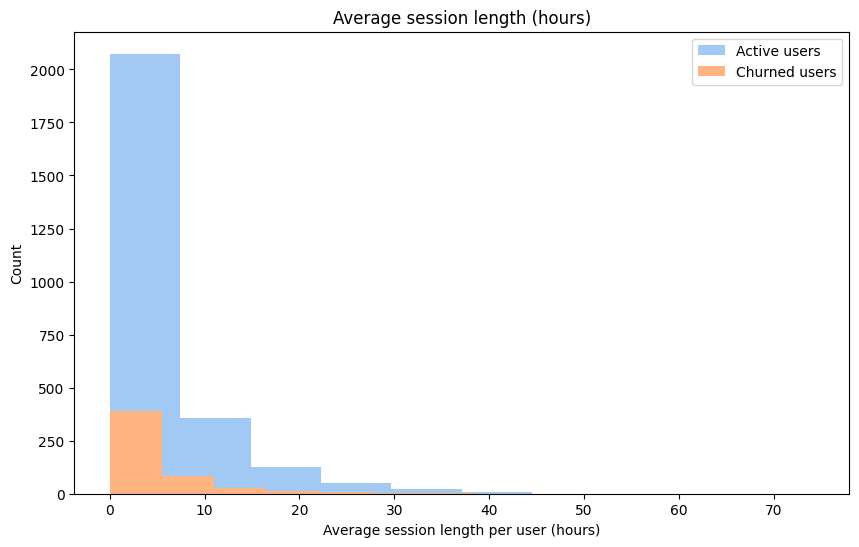


Average session length for churned users (hours):
+-------------------+
|avg(session_length)|
+-------------------+
|  4.718692338992486|
+-------------------+

Average session length for active users (hours):
+-------------------+
|avg(session_length)|
+-------------------+
|  5.047589365434434|
+-------------------+



In [52]:
# average session length per user
# udf to convert time to correct format and show time difference in hours
# source: https://stackoverflow.com/questions/30283415/calculating-duration-by-subtracting-two-datetime-columns-in-string-format
time_delta = udf(lambda y, x: (datetime.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') -
                               datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds()/3600)

# create dataframe with first timestamp (ts) per session
# add column 'churn' and set as 1 for rows with churned user
df_min = df_clean.groupBy('userId', 'sessionId').agg(min('ts').alias('min_ts'))
df_min = df_min.withColumn('churn', when((df_min.userId).isin(churned_users), 1).otherwise(0))

# create dataframe with last timestamp (ts) per session
df_max = df_clean.groupBy('userId', 'sessionId').agg(max('ts').alias('max_ts'))

# join dataframes
df_ts = df_min.join(df_max, on=['userId', 'sessionId'])

# apply udf when calculating and creating new column with time difference
df_ts = df_ts.withColumn('session_length', time_delta(df_ts['max_ts'], df_ts['min_ts']).cast('float'))

# graph of session length per user group
# store columns to be used as pandas dataframe
df_ts_pd = df_ts.select('churn', 'session_length').toPandas()

# plot results
plt.figure(figsize=(10,6))
plt.hist(df_ts_pd['session_length'][df_ts_pd['churn'] == 0], label='Active users')
plt.hist(df_ts_pd['session_length'][df_ts_pd['churn'] == 1], label='Churned users')
plt.legend(loc='upper right')
plt.title('Average session length (hours)')
plt.xlabel('Average session length per user (hours)')
plt.ylabel('Count')
plt.show()

print('')

# average session length for churned users
print('Average session length for churned users (hours):')
df_ts.where(col('churn') == 1).agg(avg('session_length')).show()

# average session length for active users
print('Average session length for active users (hours):')
df_ts.where(col('churn') == 0).agg(avg('session_length')).show()

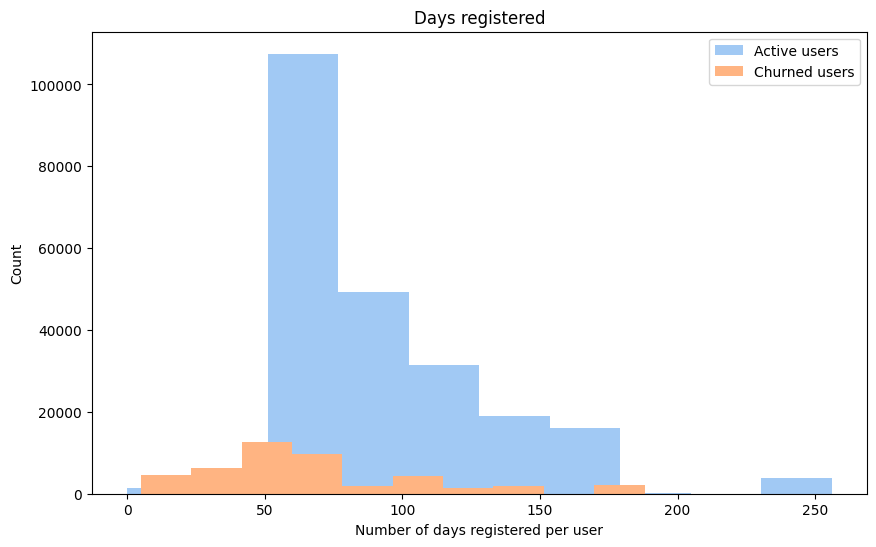


Average number of days registered for churned users:
+--------------------+
|avg(days_registered)|
+--------------------+
|   67.64847093437946|
+--------------------+

Average number of days registered for active users:
+--------------------+
|avg(days_registered)|
+--------------------+
|   92.97668995670625|
+--------------------+



In [53]:
 # average registration/usage length per user (days from registration date to ts for latest event)
# create dataframe with last timestamp (ts) per user
df_last = df_clean.groupBy('userId').agg(max('ts').alias('last_interaction'))

# join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
df_reg = df_last.join(df_clean, on='userId').select(
    df_last['*'], df_clean['registration'], df_clean['churn']).withColumn(
    'days_registered', datediff(df_last['last_interaction'], df_clean['registration']))

# graph of number of days registered per user group
# store columns to be used as pandas dataframe
df_reg_pd = df_reg.select('churn', 'days_registered').toPandas()

# plot results
plt.figure(figsize=(10,6))
plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 0], label='Active users')
plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 1], label='Churned users')
plt.legend(loc='upper right')
plt.title('Days registered')
plt.xlabel('Number of days registered per user')
plt.ylabel('Count')
plt.show()

print('')

# get average number of days registered for churned users
print('Average number of days registered for churned users:')
df_reg.where(col('churn') == 1).agg(avg('days_registered')).show()

# get average number of days registered for active users
print('Average number of days registered for active users:')
df_reg.where(col('churn') == 0).agg(avg('days_registered')).show()

In [54]:
# average number of unique artists played per user
print('Average number of unique artists played per churned user: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId').count().count()))

print('Average number of unique artists played per active user: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of unique songs played per user
print('Average number of unique songs played per churned user: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('song').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId').count().count()))

print('Average number of unique songs played per active user: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('song').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId').count().count()))

Average number of unique artists played per churned user: 162
Average number of unique artists played per active user: 96

Average number of unique songs played per churned user: 370
Average number of unique songs played per active user: 308


In [55]:
# average number of unique artists played per session
print('Average number of unique artists played per session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of unique artists played per session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

print('')

# average number of unique songs played per session
print('Average number of unique songs played per session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('song').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of unique songs played per session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('song').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

Average number of unique artists played per session for churned users: 16
Average number of unique artists played per session for active users: 6

Average number of unique songs played per session for churned users: 36
Average number of unique songs played per session for active users: 20


In [56]:
# percent paid and free plans of churned users
print('Share of churned users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

print('Share of churned users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

print('')

# percent paid and free plans of active users
print('Share of active users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))

print('Share of active users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))

Share of churned users that are on a paid plan: 44%
Share of churned users that are on a free plan: 56%

Share of active users that are on a paid plan: 46%
Share of active users that are on a free plan: 54%


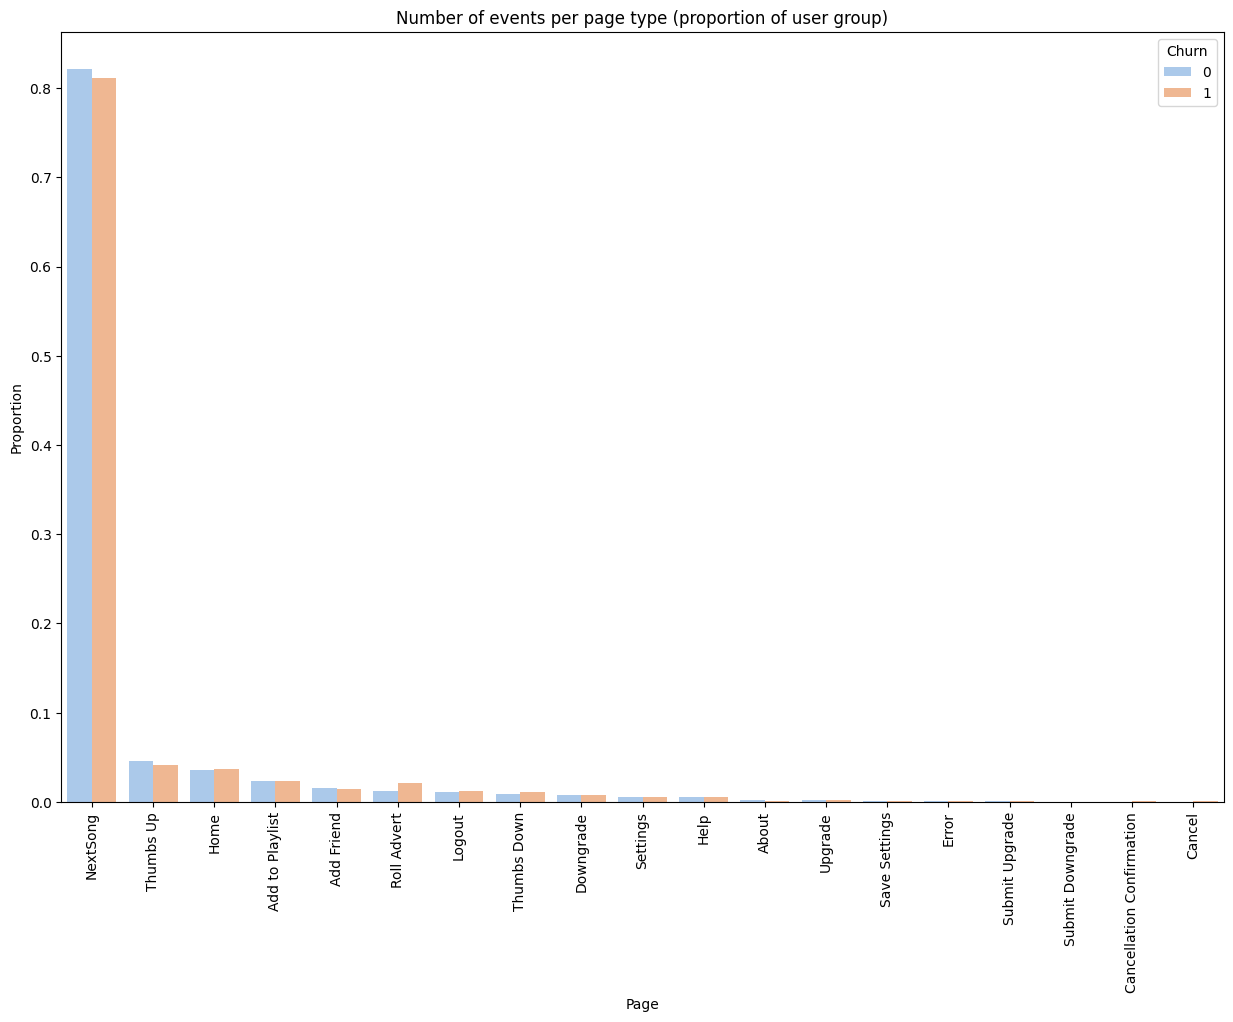


Number of events per page type for all events with a churned user:
+--------------------+-----+
|                page|count|
+--------------------+-----+
|            NextSong|36394|
|           Thumbs Up| 1859|
|                Home| 1672|
|     Add to Playlist| 1038|
|         Roll Advert|  967|
|          Add Friend|  636|
|              Logout|  553|
|         Thumbs Down|  496|
|           Downgrade|  337|
|            Settings|  270|
|                Help|  239|
|             Upgrade|  112|
|       Save Settings|   58|
|               About|   56|
|              Cancel|   52|
|Cancellation Conf...|   52|
|               Error|   32|
|      Submit Upgrade|   32|
|    Submit Downgrade|    9|
+--------------------+-----+

Number of events per page type for all events with active users:
+----------------+------+
|            page| count|
+----------------+------+
|        NextSong|191714|
|       Thumbs Up| 10692|
|            Home|  8410|
| Add to Playlist|  5488|
|      Add Friend

In [57]:
# graph of number of events per page type per user group
# plot results as proportions instead of counts
# source: https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
plt.figure(figsize=(15,10))

df_page_pd = df_clean.select('churn', 'page').toPandas()
x, y, hue = 'page', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_page_pd[x]
 .groupby(df_page_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Number of events per page type (proportion of user group)')
plt.xlabel('Page')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

print('')

print('Number of events per page type for all events with a churned user:')

df_clean.where(col('churn') == 1).groupBy('page').count().sort(desc('count')).show()

print('Number of events per page type for all events with active users:')
df_clean.where(col('churn') == 0).groupBy('page').count().sort(desc('count')).show()

In [58]:
# average number of songes played for churned and active users
print('Average number of songs played for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of songs played for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of songs played for churned users: 700
Average number of songs played for active users: 1108


In [59]:
# average number of thumbs up for churned and active users
print('Average number of thumbs up for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of thumbs up for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of thumbs up for churned users: 36
Average number of thumbs up for active users: 62


In [60]:
# average number of home page visits for churned and active users
print('Average number of home page visits for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Home') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of home page visits for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Home') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of home page visits for churned users: 32
Average number of home page visits for active users: 49


In [61]:
# average number of added friends for churned and active users
print('Average number of added friends for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of added friends for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of added friends for churned users: 12
Average number of added friends for active users: 21


In [62]:
# average number of ads received for churned and active users
print('Average number of ads received for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Roll Advert') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of ads received for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Roll Advert') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of ads received for churned users: 19
Average number of ads received for active users: 17


In [63]:
# average number of logouts for churned and active users
print('Average number of logouts for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Logout') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of logouts for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Logout') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of logouts for churned users: 11
Average number of logouts for active users: 15


In [64]:
# average number of thumbs down for churned and active users
print('Average number of thumbs down for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of thumbs down for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of thumbs down for churned users: 10
Average number of thumbs down for active users: 12


In [65]:
# average number of settings page visits for churned and active users
print('Average number of settings page visits for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Settings') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of settings page visits for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Settings') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of settings page visits for churned users: 5
Average number of settings page visits for active users: 7


In [66]:
# average number of plan upgrades for churned and active users
print('Average number of plan upgrades for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Upgrade') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of plan upgrades for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Upgrade') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of plan upgrades for churned users: 2
Average number of plan upgrades for active users: 2


In [67]:
# number of females in dataset
print('Number of female users in dataset: {:.0f}'.format(
df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count()))

# number of males in dataset
print('Number of male users in dataset: {:.0f}'.format(
df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count()))

Number of female users in dataset: 104
Number of male users in dataset: 121


In [68]:
# percent female of all events
print('Percentage of all events that where made by females: {:.0f}%'.format(
df_clean.where(df_clean.gender == 'F').count() / df_clean.count() * 100))

# percent male of all events
print('Percentage of all events that where made by males: {:.0f}%'.format(
df_clean.where(df_clean.gender == 'M').count() / df_clean.count() * 100))

Percentage of all events that where made by females: 56%
Percentage of all events that where made by males: 44%


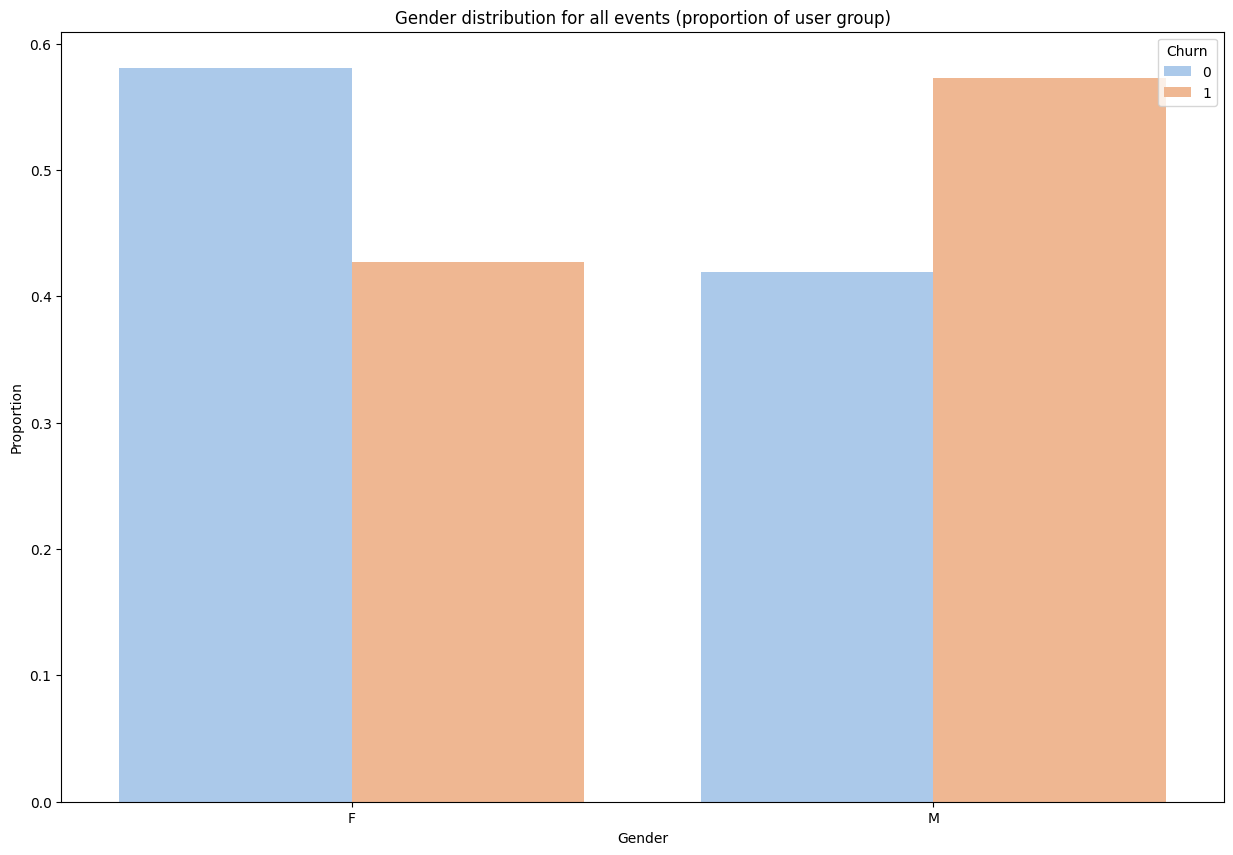


Share of churned users that are male: 62%
Share of churned users that are female: 38%

Share of active users that are male: 51%
Share of active users that are female: 49%


In [69]:
# graph of gender proportion for all events per user group
plt.figure(figsize=(15,10))

df_gender_pd = df_clean.select('churn', 'gender').toPandas()
x, y, hue = 'gender', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_gender_pd[x]
 .groupby(df_gender_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Gender distribution for all events (proportion of user group)')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

print('')

# percent males and females of churned users
print('Share of churned users that are male: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'gender').count().count() * 100))

print('Share of churned users that are female: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'gender').count().count() * 100))
print('')

# percent males and females of active users
print('Share of active users that are male: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'gender').count().count() * 100))

print('Share of active users that are female: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'gender').count().count() * 100))

In [70]:
# percent churned and active of all females
print('Share of females that are churned users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100))

print('Share of females that are active users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100))

print('')

# percent churned and active of all males
print('Share of males that are churned users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100))

print('Share of males that are active users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100))

Share of females that are churned users: 19%
Share of females that are active users: 81%

Share of males that are churned users: 26%
Share of males that are active users: 74%


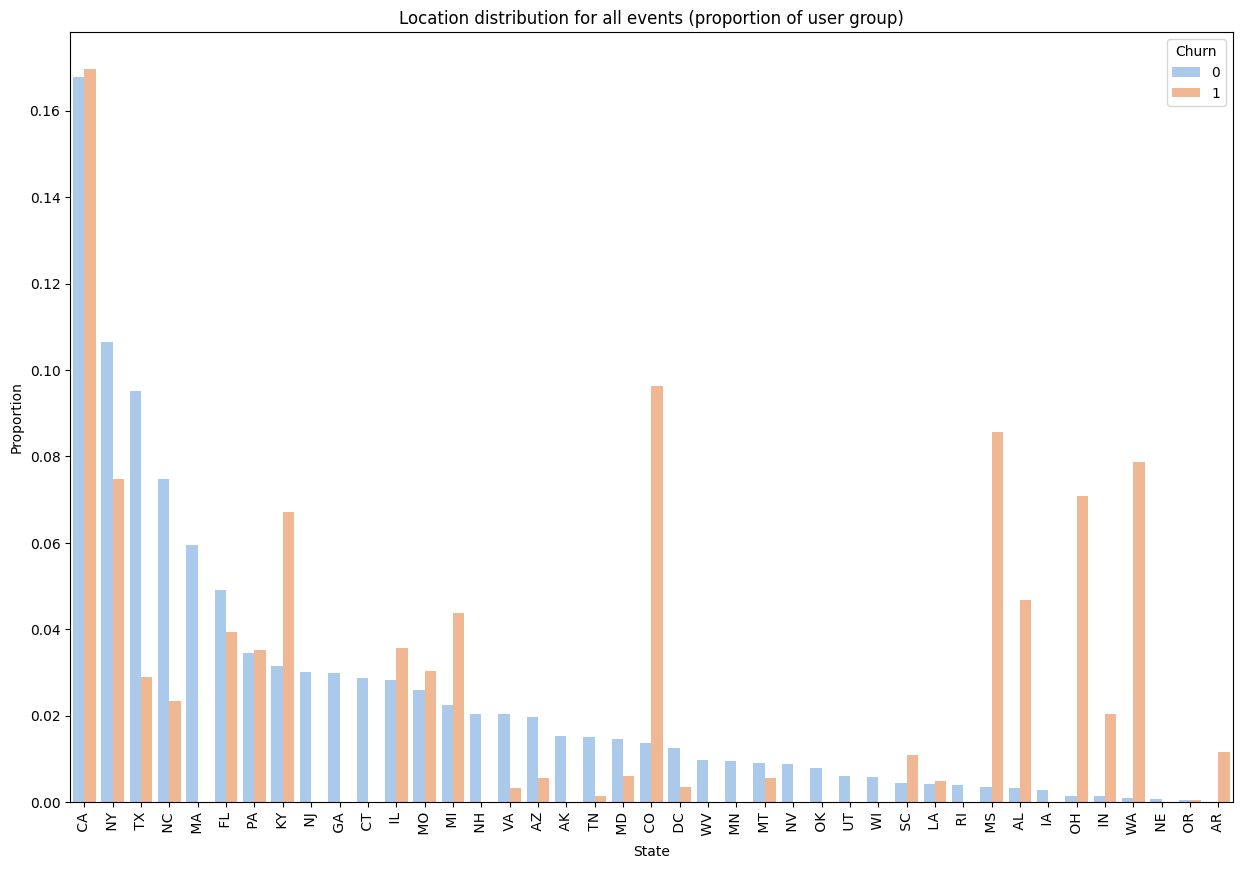


States for all events with a churned user:
+-----+-----+
|state|count|
+-----+-----+
|   CA| 7613|
|   CO| 4317|
|   MS| 3839|
|   WA| 3526|
|   NY| 3356|
|   OH| 3173|
|   KY| 3016|
|   AL| 2102|
|   MI| 1958|
|   FL| 1763|
|   IL| 1603|
|   PA| 1580|
|   MO| 1361|
|   TX| 1294|
|   NC| 1050|
|   IN|  918|
|   AR|  520|
|   SC|  494|
|   MD|  268|
|   MT|  254|
|   AZ|  251|
|   LA|  216|
|   DC|  158|
|   VA|  149|
|   TN|   62|
|   OR|   23|
+-----+-----+

States for all events with an active user:
+-----+-----+
|state|count|
+-----+-----+
|   CA|39158|
|   NY|24864|
|   TX|22200|
|   NC|17418|
|   MA|13873|
|   FL|11427|
|   PA| 8048|
|   KY| 7326|
|   NJ| 7001|
|   GA| 6952|
|   CT| 6720|
|   IL| 6616|
|   MO| 6059|
|   MI| 5258|
|   NH| 4764|
|   VA| 4748|
|   AZ| 4595|
|   AK| 3563|
|   TN| 3535|
|   MD| 3424|
|   CO| 3176|
|   DC| 2932|
|   WV| 2278|
|   MN| 2241|
|   MT| 2132|
|   NV| 2042|
|   OK| 1842|
|   UT| 1419|
|   WI| 1342|
|   SC| 1011|
|   LA|  955|
|   RI|  927|
| 

In [71]:
# graph of location distribution for all events per user group
plt.figure(figsize=(15,10))

df_location_pd = df_clean.select('churn', 'state').toPandas()
x, y, hue = 'state', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_location_pd[x]
 .groupby(df_location_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Location distribution for all events (proportion of user group)')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

print('')

print('States for all events with a churned user:')
df_clean.where(col('churn') == 1).groupBy('state').count().sort(desc('count')).show(40)

print('States for all events with an active user:')
df_clean.where(col('churn') == 0).groupBy('state').count().sort(desc('count')).show(40)

**Feature Engineering**

In [72]:
# calculate and add new columns

# create partitions
w1 = Window.partitionBy('userId')
w2 = Window.partitionBy('userId', 'sessionId')
w3 = Window.partitionBy('userId', 'artist')
w4 = Window.partitionBy('userId', 'song')

# total_events - column with total number of events per user
# create dataframe with row counts per user
df_events = df_clean.select('userId', count('userId').over(w1).alias('total_events')).distinct()
df_events = df_events.select(col('userId').alias('userId1'), 'total_events')

# total_sessions - column with total number of sessions per user
# create dataframe with session counts per user
df_sessions = df_clean.select('userId', 'sessionId', count('userId').over(w2).alias('count')).distinct()
df_sessions = df_sessions.withColumn('total_sessions', count('sessionId').over(w1))
df_sessions = df_sessions.dropDuplicates(['userId'])
df_sessions = df_sessions.select(col('userId').alias('userId2'), 'total_sessions')

# min_ts_session and max_ts_session - columns with timestamp from first and latest event per user and session
# session_length - column with session length in hours per session
# avg_session_length - column with average session length per user
# udf to convert time to correct format and show time difference in hours
time_delta = udf(lambda y, x: (datetime.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') -
                                   datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds()/3600)

# create columns with timestamp (ts) from first and latest event per user and session
df_clean = df_clean.withColumn('min_ts_session', min('ts').over(w2))
df_clean = df_clean.withColumn('max_ts_session', max('ts').over(w2))

# apply udf when creating column with time difference (in hours)
df_clean = df_clean.withColumn('session_length', time_delta(df_clean['max_ts_session'],
                                                            df_clean['min_ts_session']).cast('float'))

# create column with average session length per user (in hours)
df_clean = df_clean.withColumn('avg_session_length', avg('session_length').over(w1))

# latest_ts and days_registered - columns with timestamp from latest event and with number of days registered
# create column with timestamp (ts) from latest event per user
df_clean = df_clean.withColumn('latest_ts', max('ts').over(w1))

# create column 'days_registered'
df_clean = df_clean.withColumn('days_registered', datediff(df_clean['latest_ts'], df_clean['registration']))

# unique_artists - column with number of unique artists played per user
# create dataframe with artist counts per user
df_artist = df_clean.select('userId', 'artist', count('userId').over(w3).alias('count')).distinct()
df_artist = df_artist.withColumn('unique_artists', count('artist').over(w1))
df_artist = df_artist.dropDuplicates(['userId'])
df_artist = df_artist.select(col('userId').alias('userId3'), 'unique_artists')

# unique_songs - column with number of unique songs played per user
# create dataframe with song counts per user
df_song = df_clean.select('userId', 'song', count('userId').over(w4).alias('count')).distinct()
df_song = df_song.withColumn('unique_songs', count('song').over(w1))
df_song = df_song.dropDuplicates(['userId'])
df_song = df_song.select(col('userId').alias('userId4'), 'unique_songs')

# total_nextsong - column with number of 'NextSong' events per user
# create dataframe with 'page = NextSong' counts per user
df_nextsong = df_clean.where(df_clean.page == 'NextSong').select(
    'userId', count('userId').over(w1).alias('total_nextsong')).distinct()
df_nextsong = df_nextsong.select(col('userId').alias('userId5'), 'total_nextsong')

# total_thumbsup - column with number of 'Thumbs Up' events per user
# create dataframe with 'page = Thumbs Up' counts per user
df_thumbsup = df_clean.where(df_clean.page == 'Thumbs Up').select(
    'userId', count('userId').over(w1).alias('total_thumbsup')).distinct()
df_thumbsup = df_thumbsup.select(col('userId').alias('userId6'), 'total_thumbsup')


# total_home - column with number of 'Home' events per user
# create dataframe with 'page = Home' counts per user
df_home = df_clean.where(df_clean.page == 'Home').select(
    'userId', count('userId').over(w1).alias('total_home')).distinct()
df_home = df_home.select(col('userId').alias('userId7'), 'total_home')

# total_addfriend - column with number of 'Add Friend' events per user
# create dataframe with 'page = Add Friend' counts per user
df_addfriend = df_clean.where(df_clean.page == 'Add Friend').select(
    'userId', count('userId').over(w1).alias('total_addfriend')).distinct()
df_addfriend = df_addfriend.select(col('userId').alias('userId8'), 'total_addfriend')

# total_rolladvert - column with number of 'Roll Advert' events per user
# create dataframe with 'page = Roll Advert' counts per user
df_rolladvert = df_clean.where(df_clean.page == 'Roll Advert').select(
    'userId', count('userId').over(w1).alias('total_rolladvert')).distinct()
df_rolladvert = df_rolladvert.select(col('userId').alias('userId9'), 'total_rolladvert')

# latest_event - column indicating row with latest event per user
df_clean = df_clean.withColumn('latest_event', when(df_clean.latest_ts == df_clean.ts, 1).otherwise(0))

# keep only row with latest event per user in data to be used for modeling
df_ml = df_clean.where(col('latest_event') == 1)

# drop duplicates from dataframe
df_ml = df_ml.dropDuplicates(['userId'])

# recode 'gender' to numerical binary
df_ml = df_ml.withColumn('gender', when(df_ml.gender == 'F', 1).otherwise(0))

# only keep columns to be used in modeling and replace NaN with 0
df_ml = df_ml.select('userId', 'churn', 'gender', 'state', 'avg_session_length',
                     'days_registered', ).fillna(0)

# add columns to df_ml and replace NaN with 0 for column
# add column 'total_events'
df_ml = df_ml.join(df_events, df_ml.userId == df_events.userId1, how='left').select(
    df_ml['*'], df_events['total_events']).fillna(0, subset=['total_events'])

# add column 'total_sessions'
df_ml = df_ml.join(df_sessions, df_ml.userId == df_sessions.userId2, how='left').select(
    df_ml['*'], df_sessions['total_sessions']).fillna(0, subset=['total_sessions'])

# add column 'unique_artists'
df_ml = df_ml.join(df_artist, df_ml.userId == df_artist.userId3, how='left').select(
    df_ml['*'], df_artist['unique_artists']).fillna(0, subset=['unique_artists'])

# add column 'unique_songs'
df_ml = df_ml.join(df_song, df_ml.userId == df_song.userId4, how='left').select(
    df_ml['*'], df_song['unique_songs']).fillna(0, subset=['unique_songs'])

# add column 'total_nextsong'
df_ml = df_ml.join(df_nextsong, df_ml.userId == df_nextsong.userId5, how='left').select(
    df_ml['*'], df_nextsong['total_nextsong']).fillna(0, subset=['total_nextsong'])

# add column 'total_thumbsup'
df_ml = df_ml.join(df_thumbsup, df_ml.userId == df_thumbsup.userId6, how='left').select(
    df_ml['*'], df_thumbsup['total_thumbsup']).fillna(0, subset=['total_thumbsup'])

# add column 'total_home'
df_ml = df_ml.join(df_home, df_ml.userId == df_home.userId7, how='left').select(
    df_ml['*'], df_home['total_home']).fillna(0, subset=['total_home'])

# add column 'total_addfriend'
df_ml = df_ml.join(df_addfriend, df_ml.userId == df_addfriend.userId8, how='left').select(
    df_ml['*'], df_addfriend['total_addfriend']).fillna(0, subset=['total_addfriend'])

# add column 'total_rolladvert'
df_ml = df_ml.join(df_rolladvert, df_ml.userId == df_rolladvert.userId9, how='left').select(
    df_ml['*'], df_rolladvert['total_rolladvert']).fillna(0, subset=['total_rolladvert'])

In [73]:
df_ml.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- avg_session_length: double (nullable = false)
 |-- days_registered: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- unique_artists: long (nullable = true)
 |-- unique_songs: long (nullable = true)
 |-- total_nextsong: long (nullable = true)
 |-- total_thumbsup: long (nullable = true)
 |-- total_home: long (nullable = true)
 |-- total_addfriend: long (nullable = true)
 |-- total_rolladvert: long (nullable = true)



In [74]:
df_ml.cache()

DataFrame[userId: string, churn: int, gender: int, state: string, avg_session_length: double, days_registered: int, total_events: bigint, total_sessions: bigint, unique_artists: bigint, unique_songs: bigint, total_nextsong: bigint, total_thumbsup: bigint, total_home: bigint, total_addfriend: bigint, total_rolladvert: bigint]

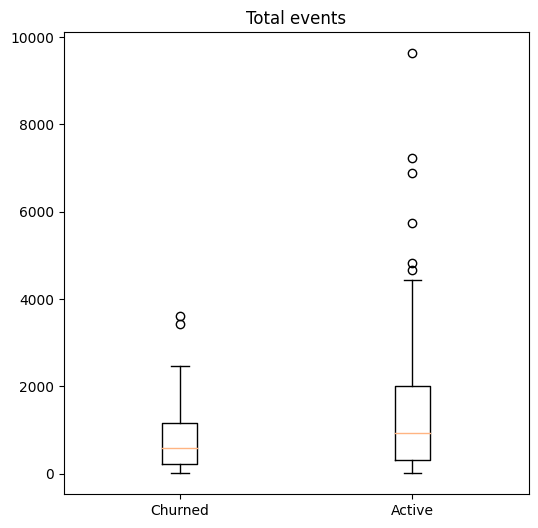

Basic statistics for churned users:
Basic statistics for active users:


count     173.000000
mean     1348.497110
std      1425.428637
min         6.000000
25%       321.000000
50%       940.000000
75%      2005.000000
max      9632.000000
dtype: float64

In [75]:
# plot total_events
# store column values as array
churn = df_ml.select('total_events').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_events').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_events'].tolist()
active = active['total_events'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total events')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

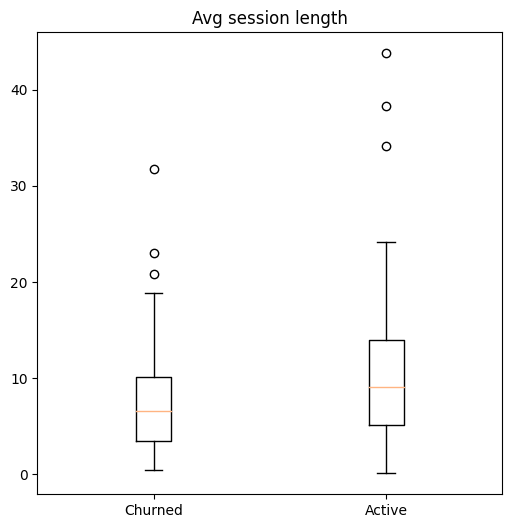

Basic statistics for churned users:
Basic statistics for active users:


count    173.000000
mean      10.080304
std        6.913497
min        0.116667
25%        5.094973
50%        9.100278
75%       13.971460
max       43.795572
dtype: float64

In [76]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('avg_session_length').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('avg_session_length').where(df_ml['churn'] == 0).toPandas()

churn = churn['avg_session_length'].tolist()
active = active['avg_session_length'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Avg session length')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

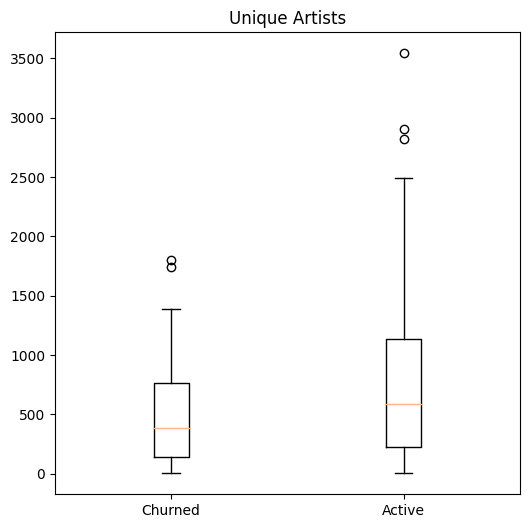

Basic statistics for churned users:
Basic statistics for active users:


count     173.000000
mean      749.786127
std       633.235440
min         3.000000
25%       226.000000
50%       587.000000
75%      1137.000000
max      3544.000000
dtype: float64

In [77]:
# plot days_registered
# store column values as array
churn = df_ml.select('unique_artists').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('unique_artists').where(df_ml['churn'] == 0).toPandas()

churn = churn['unique_artists'].tolist()
active = active['unique_artists'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Unique Artists')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

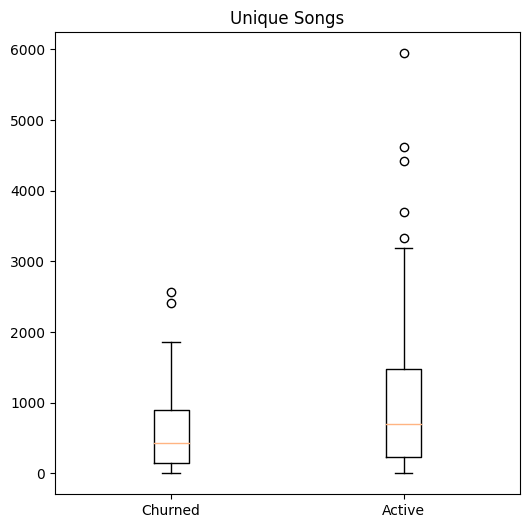

Basic statistics for churned users:
Basic statistics for active users:


count     173.000000
mean      975.768786
std       951.912881
min         3.000000
25%       239.000000
50%       696.000000
75%      1477.000000
max      5946.000000
dtype: float64

In [78]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('unique_songs').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('unique_songs').where(df_ml['churn'] == 0).toPandas()

churn = churn['unique_songs'].tolist()
active = active['unique_songs'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Unique Songs')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

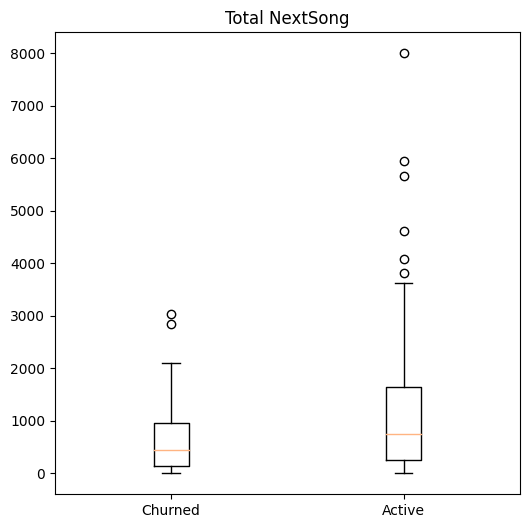

Basic statistics for churned users:
Basic statistics for active users:


count     173.000000
mean     1108.173410
std      1183.146703
min         3.000000
25%       251.000000
50%       747.000000
75%      1640.000000
max      8002.000000
dtype: float64

In [79]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('total_nextsong').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_nextsong').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_nextsong'].tolist()
active = active['total_nextsong'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total NextSong')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

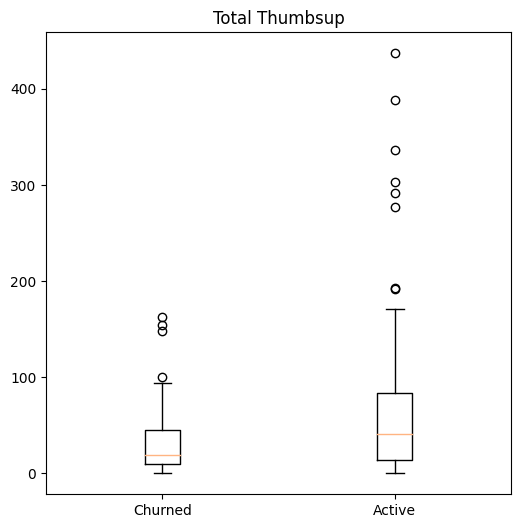

Basic statistics for churned users:
Basic statistics for active users:


count    173.000000
mean      61.803468
std       70.416424
min        0.000000
25%       14.000000
50%       41.000000
75%       84.000000
max      437.000000
dtype: float64

In [80]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('total_thumbsup').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_thumbsup').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_thumbsup'].tolist()
active = active['total_thumbsup'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total Thumbsup')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

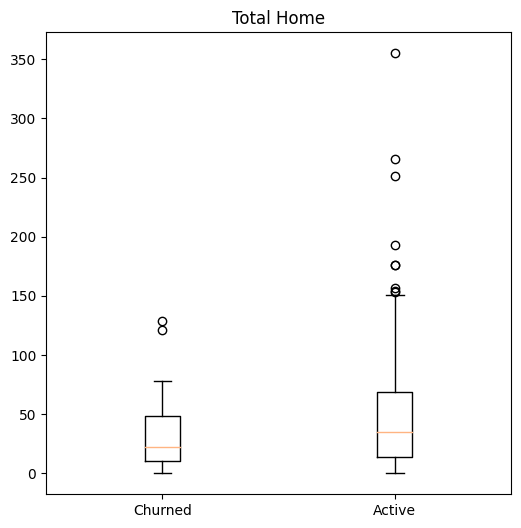

Basic statistics for churned users:
Basic statistics for active users:


count    173.000000
mean      48.612717
std       50.936181
min        0.000000
25%       14.000000
50%       35.000000
75%       69.000000
max      355.000000
dtype: float64

In [81]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('total_home').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_home').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_home'].tolist()
active = active['total_home'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total Home')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

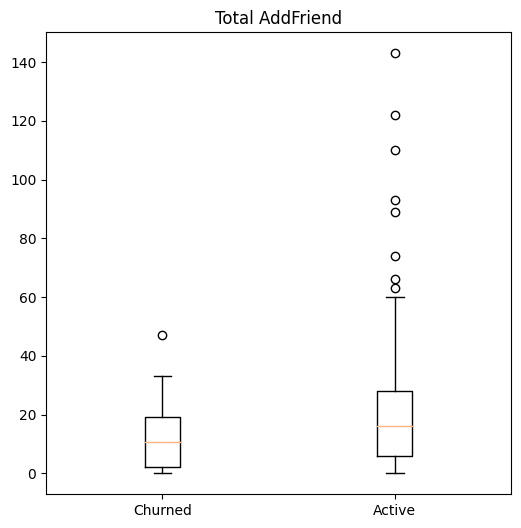

Basic statistics for churned users:
Basic statistics for active users:


count    173.000000
mean      21.046243
std       22.286667
min        0.000000
25%        6.000000
50%       16.000000
75%       28.000000
max      143.000000
dtype: float64

In [82]:
# plot avg_session_length
# store column values as array
churn = df_ml.select('total_addfriend').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_addfriend').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_addfriend'].tolist()
active = active['total_addfriend'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total AddFriend')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

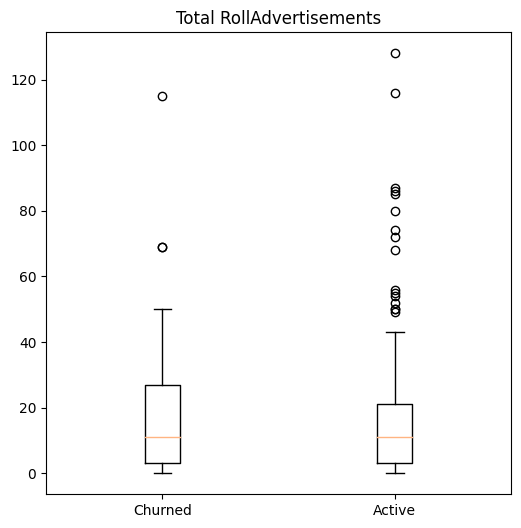

Basic statistics for churned users:
Basic statistics for active users:


count    173.000000
mean      17.144509
std       21.527077
min        0.000000
25%        3.000000
50%       11.000000
75%       21.000000
max      128.000000
dtype: float64

In [84]:
# plot roll_advert
# store column values as array
churn = df_ml.select('total_rolladvert').where(df_ml['churn'] == 1).toPandas()
active = df_ml.select('total_rolladvert').where(df_ml['churn'] == 0).toPandas()

churn = churn['total_rolladvert'].tolist()
active = active['total_rolladvert'].tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total RollAdvertisements')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
churn = pd.Series(churn)
churn.describe()

print('Basic statistics for active users:')
active = pd.Series(active)
active.describe()

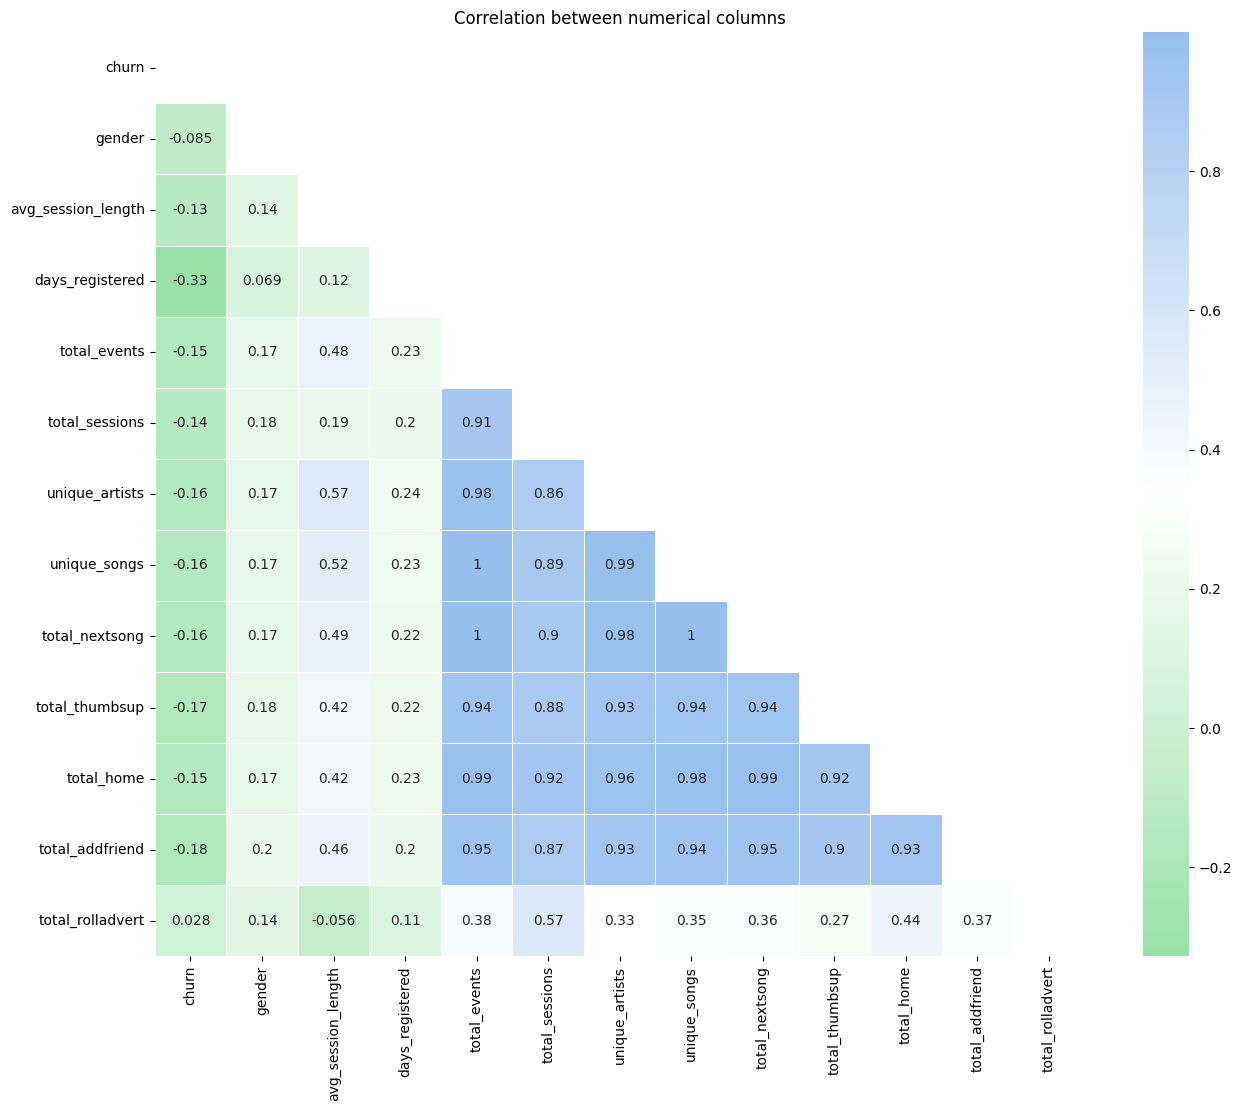

In [85]:
import matplotlib.colors as mcolors

# Filter out non-numeric columns before computing correlation
numeric_cols = [col_name for col_name, dtype in df_ml.dtypes if dtype != 'string']
df_numeric = df_ml.select(numeric_cols)

# Now compute the correlation matrix
df_corr = df_numeric.toPandas().corr()

# Plot the correlation matrix
plt.figure(figsize=(15,12))
plt.title('Correlation between numerical columns')

# Create a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

# Create custom color range for heatmap to match other graphs in notebook
cmap = mcolors.LinearSegmentedColormap.from_list('n', ['#99E1A8', '#FFFFFF', '#97BFEE'])

# Plot heatmap
sns.heatmap(df_corr, mask=mask, annot=True, linewidths=0.5, cmap=cmap)
plt.show()

In [86]:
# data modeling preparation pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline


# list of numerical columns
numerical_cols = ['avg_session_length',
                  'days_registered',
                  'total_events',
                  'total_sessions',
                  'unique_artists',
                  'unique_songs',
                  'total_nextsong',
                  'total_thumbsup',
                  'total_home',
                  'total_addfriend',
                  'total_rolladvert']

# convert sting column to index column
indexer = StringIndexer(inputCol='state', outputCol='stateIndex', handleInvalid='keep')
inputs = [indexer.getOutputCol(), 'gender']
# one hot encode categorical columns to numerical vector columns
encoder = OneHotEncoder(inputCols=inputs, outputCols=['stateVec', 'genderVec'], handleInvalid='keep')
# transform numerical columns to a single vector column
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_features')
# apply scaler (MinMax scaler preserves original data distribution)
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')
# transform all create vector columns into one vector column
assembler = VectorAssembler(inputCols=['stateVec', 'genderVec', 'scaled_features'], outputCol='features')
# create pipeline with above steps
data_pipeline = Pipeline(stages=[indexer, encoder, num_assembler, scaler, assembler])
# fit dataframe to pipleine and transform
df_ml = data_pipeline.fit(df_ml).transform(df_ml)

In [87]:
df_ml.toPandas().head(1)

,userId,churn,gender,state,avg_session_length,days_registered,total_events,total_sessions,unique_artists,unique_songs,total_nextsong,total_thumbsup,total_home,total_addfriend,total_rolladvert,stateIndex,stateVec,genderVec,num_features,scaled_features,features
0,100010,0,1,CT,3.389725,55,381,7,252,269,275,17,11,4,52,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","[3.3897250685791955, 55.0, 381.0, 7.0, 252.0, 269.0, 275.0, 17.0, 11.0, 4.0, 52.0]","[0.0749345339549984, 0.21484375, 0.03895699148140453, 0.05660377358490566, 0.07031911889296809, 0.0447585394581861, 0.034004250531316414, 0.038901601830663615, 0.030985915492957747, 0.027972027972027972, 0.40625]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0749345339549984, 0.21484375, 0.03895699148140453, 0.05660377358490566, 0.07031911889296809, 0.0447585394581861, 0.034004250531316414, 0.038901601830663615, 0.030985915492957747, 0.027972027972027972, 0.40625)"


In [90]:
# split data into train, validation and test sets
train, validation_test = df_ml.randomSplit([0.7, 0.3], seed = 4)
validation, test = validation_test.randomSplit([0.5, 0.5], seed = 4)

# shape of datasets (spark random split doesn't guarantee a split exactly to the input weigths)
print('Shape of train, validation and test sets:')
print((train.count(), len(train.columns)))
print((validation.count(), len(validation.columns)))
print((test.count(), len(test.columns)))

Shape of train, validation and test sets:
(156, 21)
(14, 21)
(55, 21)


In [91]:
# set up and fit models to training data
# baseline results for each model without any hyperparameter tuning
# add timer to see how long it takes to train each model

from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import LinearSVC
from time import time

# naive bayes
start1 = time()
nb = NaiveBayes(featuresCol='features', labelCol='churn')
nb_model = nb.fit(train)
end1 = time()

print('Total training time for naive bayes: {} seconds'.format(end1 - start1))

# logistic regression
start2 = time()
lr = LogisticRegression(featuresCol='features', labelCol='churn')
lr_model = lr.fit(train)
end2 = time()

print('Total training time for logic regression: {} seconds'.format(end2 - start2))

# linear svc (support vector machine)
start3 = time()
svc = LinearSVC(featuresCol='features', labelCol='churn')
svc_model = svc.fit(train)
end3 = time()

print('Total training time for linear svc: {} seconds'.format(end3 - start3))

# random forest
start4 = time()
rf = RandomForestClassifier(featuresCol='features', labelCol='churn', seed=4)
rf_model = rf.fit(train)
end4 = time()

print('Total training time for random forest: {} seconds'.format(end4 - start4))

# decision tree
start5 = time()
dt = DecisionTreeClassifier(featuresCol='features', labelCol='churn', seed=4)
dt_model = dt.fit(train)
end5 = time()

print('Total training time for decision tree: {} seconds'.format(end5 - start5))




Total training time for naive bayes: 11.462976455688477 seconds
Total training time for logic regression: 422.9518897533417 seconds
Total training time for linear svc: 735.3697195053101 seconds
Total training time for random forest: 60.407700538635254 seconds
Total training time for decision tree: 39.587690591812134 seconds


In [92]:
# baseline model predictions
# create lists with the models and their respective names
models = [nb_model,
          lr_model,
          svc_model,
          rf_model,
          dt_model]

model_names = ['naive bayes',
               'logistic regression',
               'linear svc',
               'random forest',
               'decision tree']

# for all models, make prediction, calculate f1 scores and display results
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    # predict on validation set
    validation_prediction = model.transform(validation)
    # use MulticlassClassificationEvaluator to get f1 scores
    evaluator1 = MulticlassClassificationEvaluator(labelCol='churn')
    # use BinaryClassificationEvaluator to get area under PR
    evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churn')
    # make evaluation and print f1-score and area under PR per model
    print('F1 score for {} on validation set: {}'.format((model_name), (evaluator1.evaluate(
        validation_prediction, {evaluator1.metricName:'f1'}))))

    print('Area under PR for {} on validation set: {}'.format((model_name), (evaluator2.evaluate(
        validation_prediction, {evaluator2.metricName:'areaUnderPR'}))))

    print('')

F1 score for naive bayes on validation set: 0.6149068322981366
Area under PR for naive bayes on validation set: 0.10714285714285714

F1 score for logistic regression on validation set: 0.5714285714285714
Area under PR for logistic regression on validation set: 0.10714285714285714

F1 score for linear svc on validation set: 0.5714285714285714
Area under PR for linear svc on validation set: 0.10714285714285714

F1 score for random forest on validation set: 0.8273809523809522
Area under PR for random forest on validation set: 0.7380952380952381

F1 score for decision tree on validation set: 0.7357142857142855
Area under PR for decision tree on validation set: 0.36904761904761907



In [93]:
# get parameter options for decision tree model
rf.explainParams()

"bootstrap: Whether bootstrap samples are used when building trees. (default: True)\ncacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the fe

In [95]:
# tune hyperparapeters with ParamGridBuilder and CrossValidator
# build paramGrid with hyperparameters to tune
paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity,['entropy', 'gini']) # default: gini
            .addGrid(rf.maxDepth, [5, 10, 15]) # default: 5
            .build())
# add paramGrid to CrossValidator
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds = 5)

# fit cv model
start7 = time()
cv_rf = crossval.fit(train)
end7 = time()

print('Total training time for hyperparameter tuning on random forest model: {} seconds'.format(end7 - start7))

Total training time for hyperparameter tuning on random forest model: 1920.4084079265594 seconds


In [107]:
# predict on validation set
validation_prediction_rf = cv_rf.transform(validation)

# make evaluation and print f1-score
print('F1 score for tuned random forest model on validation set: {}'.format(evaluator1.evaluate(
    validation_prediction_rf, {evaluator1.metricName:'f1'})))

F1 score for tuned random forest model on validation set: 0.8273809523809522


In [108]:
# predict on test set
test_prediction_rf = cv_rf.transform(test)

# make evaluation and print f1-score
print('F1 score for tuned random forest model on test set: {}'.format(evaluator1.evaluate(test_prediction_rf,
                                                                     {evaluator1.metricName:'f1'})))

F1 score for tuned random forest model on test set: 0.6726980884284255


In [109]:
# test baseline random forest model on test set
# predict on test set
test_prediction_rf_baseline = rf_model.transform(test)

# make evaluation and print f1-score
print('F1 score for baseline random forest model on test set: {}'.format(evaluator1.evaluate(
            test_prediction_rf_baseline, {evaluator1.metricName:'f1'})))

F1 score for baseline random forest model on test set: 0.6180939833113747


In [99]:
cv_rf.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_b12d450b4939', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_b12d450b4939', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_b12d450b4939', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_b12d450b4939', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [100]:
# function to extract feature importance score and name for model, convert to pandas dataframe and
# add column with cumulative score
# source: https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-
# score-creating-a-pyspark-estimator/

def extract_feature_imp(featureImp, dataset, featuresCol):
    # dictionary to replace vector name with feature name
    feat_name_dict = {
        'scaled_features_0': 'avg_session_length',
        'scaled_features_1': 'days_registered',
        'scaled_features_2': 'total_events',
        'scaled_features_3': 'total_sessions',
        'scaled_features_4': 'unique_artists',
        'scaled_features_5': 'unique_songs',
        'scaled_features_6': 'total_nextsong',
        'scaled_features_7': 'total_thumbsup',
        'scaled_features_8': 'total_home',
        'scaled_features_9': 'total_addfriend',
        'scaled_features_10': 'total_rolladvert',
        'stateVec_ CA': 'state: CA',
        'stateVec_ NY': 'state: NY',
        'stateVec_ TX': 'state: TX',
        'stateVec_ FL': 'state: FL',
        'stateVec_ NC': 'state: NC',
        'stateVec_ IL': 'state: IL',
        'stateVec_ PA': 'state: PA',
        'stateVec_ MO': 'state: MO',
        'stateVec_ CT': 'state: CT',
        'stateVec_ AZ': 'state: AZ',
        'stateVec_ GA': 'state: GA',
        'stateVec_ OH': 'state: OH',
        'stateVec_ MA': 'state: MA',
        'stateVec_ MI': 'state: MI',
        'stateVec_ DC': 'state: DC',
        'stateVec_ CO': 'state: CO',
        'stateVec_ AL': 'state: AL',
        'stateVec_ VA': 'state: VA',
        'stateVec_ KY': 'state: KY',
        'stateVec_ WA': 'state: WA',
        'stateVec_ OR': 'state: OR',
         'stateVec_ MS': 'state: MS',
        'stateVec_ SC': 'state: SC',
        'stateVec_ MN': 'state: MN',
        'stateVec_ IN': 'state: IN',
        'stateVec_ TN': 'state: TN',
        'stateVec_ MD': 'state: MD',
        'stateVec_ NV': 'state: NV',
        'stateVec_ RI': 'state: RI',
        'stateVec_ MT': 'state: MT',
        'stateVec_ NH': 'state: NH',
        'stateVec_ LA': 'state: LA',
        'stateVec_ UT': 'state: UT',
        'stateVec_ AK': 'state: AK',
        'stateVec_ NJ': 'state: NJ',
        'stateVec_ WI': 'state: WI',
        'stateVec_ WV': 'state: WV',
        'stateVec_ IA': 'state: IA',
        'stateVec_ OK': 'state: OK',
        'stateVec_ NE': 'state: NE',
        'stateVec_ AR': 'state: AR',
        'stateVec___unknown': 'state:__unknown',
        'genderVec_0': 'gender: male',
        'genderVec_1': 'gender: female'}

    list_extract = []

    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]

   # create pandas dataframe with index and feature vector name from metadata
    df = pd.DataFrame(list_extract)
    # add column with feature importance score
    df['score'] = df['idx'].apply(lambda x: featureImp[x])
    df = df.sort_values('score', ascending = False)
    # add column with cumulative feature importance score
    df['cumulative_score'] = df['score'].cumsum()
    # replace feature vector name with feature name
    df['name'] = df['name'].map(feat_name_dict)

    return df

In [101]:
# get dataframe with feature importance
df_feat_imp_rf = extract_feature_imp(cv_rf.bestModel.featureImportances, df_ml, 'features')
df_feat_imp_rf.head(15)

,idx,name,score,cumulative_score
1,45,days_registered,0.197506,0.197506
7,51,total_thumbsup,0.077596,0.275102
0,44,avg_session_length,0.066996,0.342098
10,54,total_rolladvert,0.064591,0.406689
6,50,total_nextsong,0.055441,0.462130
5,49,unique_songs,0.054210,0.516340
8,52,total_home,0.051916,0.568256
2,46,total_events,0.050251,0.618507
9,53,total_addfriend,0.048804,0.667311
4,48,unique_artists,0.048370,0.715680


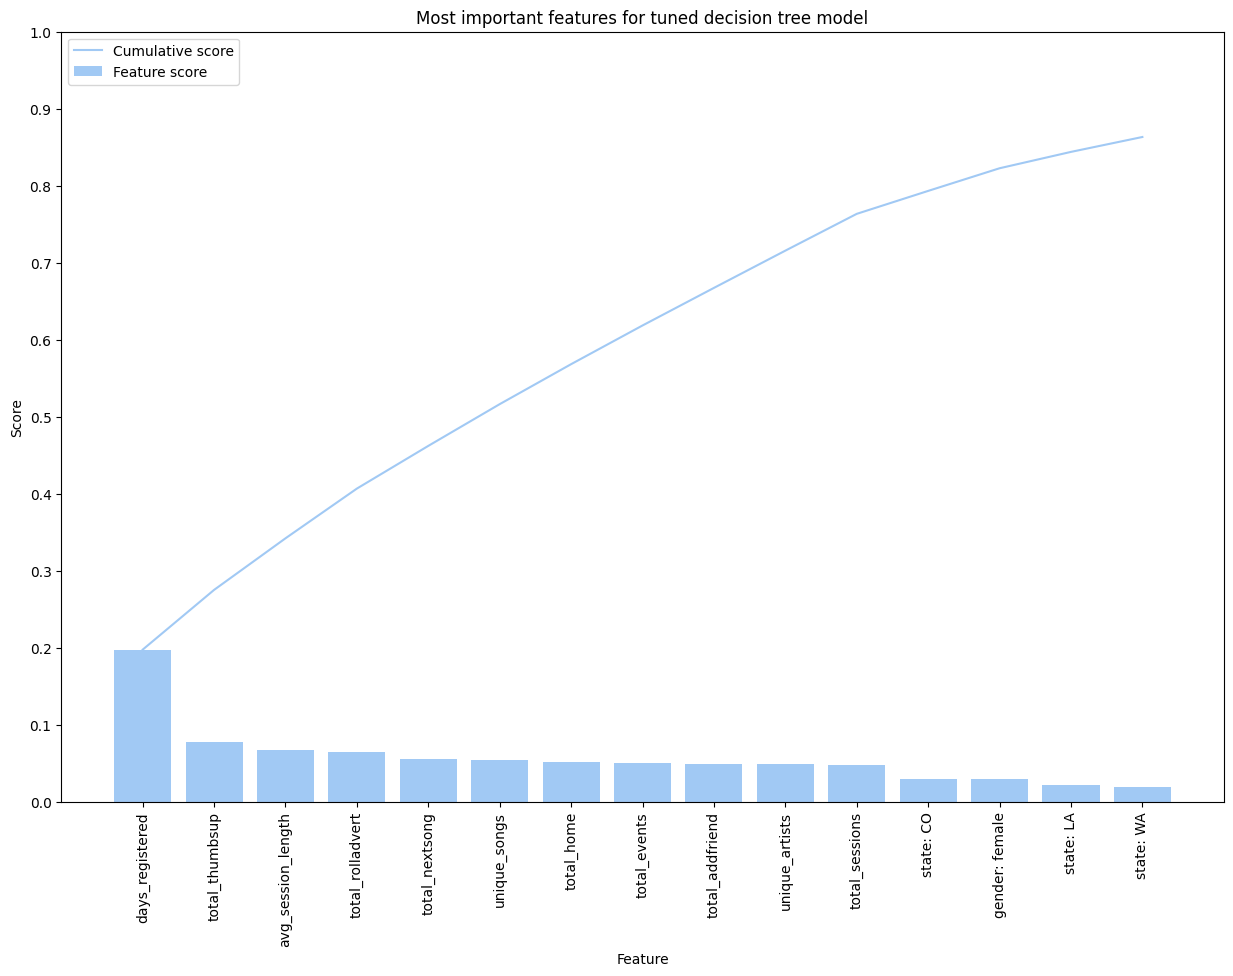

In [103]:
# plot feature score and cumulative score for most important features for tuned decision tree model
# keep only top 15 most important features for plotting
df_feat_imp_rf_15 = df_feat_imp_rf.head(15)

ind = np.arange(len(df_feat_imp_rf_15['name']))

fig = plt.figure(figsize = (15,10))
plt.bar(ind, df_feat_imp_rf_15['score'], label='Feature score')
plt.plot(ind, df_feat_imp_rf_15['cumulative_score'], label='Cumulative score')
plt.title('Most important features for tuned decision tree model')
plt.legend(loc='upper left')
plt.ylabel('Score')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Feature')
plt.xticks(ind, df_feat_imp_rf_15['name'], rotation=90)
plt.show()